In [1]:
import json
from src.test import test

# prepare validation and test sets

from src.processing import prepare_somos_data

prepare_somos_data(
    listeners=10,
    systems=10,
    texts=50,
    num_iterations=1000,
    somos_dir='data/SOMOS',
    output_dir='data/somos_prepared',
    random_seed=1234
) 

2024-01-06 20:01:44.881158 :: VALIDATION SET PREPARED :: 57 SAMPLES
VAL min wasserstein distance: 0.03450007855828836
validation locales
us: 35
ca: 13
gb: 9
2024-01-06 20:02:17.552154 :: TEST SET PREPARED :: 54 SAMPLES
TEST min wasserstein distance: 0.017990691202849227
test locales
gb: 21
ca: 21
us: 12
2024-01-06 20:02:17.553615 :: SAVED TO data/somos_prepared


In [1]:
# define MOSNet model baseline

from src.mosnet.models import MOSNet, ProsAlignMOSNet
from src.mosnet.train import train_mosnet

MOSNET_STFT_PARAMS = {
    'n_fft': 512,
    'hop_length': 256
}

BASELINE_MOSNET_PARAMS = {
    'cnn_channels': [16, 32, 64, 128],
    'cnn_kernel_size': 3,
    'blstm_hidden_size': 128,
    'fc_hidden_size': 128,
    'fc_dropout': 0.3
}

DEVICE = 'cuda:0'
TRAIN_DIR = 'data'
VAL_PATH = 'data/somos_prepared/validation_set.csv'
TEST_PATH = 'data/somos_prepared/test_set.csv'
TRANSCRIPTS_PATH = 'data/SOMOS/all_transcripts.txt'
AUDIOS_PATH = 'data/SOMOS/audios'

In [2]:
# train baseline MOSNet model

model = MOSNet(
    stft_params=MOSNET_STFT_PARAMS,
    model_params=BASELINE_MOSNET_PARAMS
).to(DEVICE)

model = train_mosnet(
    model=model, 
    model_name='mosnet',
    train_params={
        'data_dir': TRAIN_DIR,
        'epochs': 50,
        'batch_size': 64,
        'num_workers': 5,
        'learning_rate': 1e-4
    },
    validation_params={
        'data_path': VAL_PATH,
        'transcripts_path': TRANSCRIPTS_PATH,
        'audios_path': AUDIOS_PATH
    },
    device=DEVICE,
    runs_dir='runs/prod/mosnet'
)

2024-01-11 16:51:12.406468 :: START RUN
2024-01-11 16:51:59.690364 :: EPOCH 1 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.0780, srcc: 0.0821, mse: 0.3131, ktau: 0.0551 } :: SYSTEM :: { lcc: 0.1189, srcc: 0.1364, mse: 0.3287, ktau: 0.0937 }
2024-01-11 16:52:00.672167 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.1512, srcc: 0.0635, mse: 1.4261, ktau: 0.0356 } :: SYSTEM :: { lcc: -0.0504, srcc: 0.0795, mse: 2.0377, ktau: 0.1444 }
2024-01-11 16:52:47.486017 :: EPOCH 2 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.2217, srcc: 0.2179, mse: 0.3046, ktau: 0.1469 } :: SYSTEM :: { lcc: 0.2205, srcc: 0.1473, mse: 0.2968, ktau: 0.1013 }
2024-01-11 16:52:47.894260 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.0965, srcc: 0.0634, mse: 1.4314, ktau: 0.0512 } :: SYSTEM :: { lcc: nan, srcc: nan, mse: 0.4089, ktau: nan }


/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2024-01-11 16:53:35.230307 :: EPOCH 3 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.2682, srcc: 0.2695, mse: 0.2987, ktau: 0.1820 } :: SYSTEM :: { lcc: 0.3613, srcc: 0.3495, mse: 0.2665, ktau: 0.2361 }
2024-01-11 16:53:35.594311 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.1366, srcc: 0.0953, mse: 1.4486, ktau: 0.0705 } :: SYSTEM :: { lcc: 0.4067, srcc: 0.3247, mse: 1.6734, ktau: 0.3709 }
2024-01-11 16:54:22.593361 :: EPOCH 4 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.3050, srcc: 0.3094, mse: 0.2933, ktau: 0.2094 } :: SYSTEM :: { lcc: 0.1849, srcc: 0.1829, mse: 0.3052, ktau: 0.1303 }
2024-01-11 16:54:22.957002 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: -0.0288, srcc: -0.0217, mse: 1.5093, ktau: -0.0306 } :: SYSTEM :: { lcc: -0.1434, srcc: -0.2222, mse: 1.4510, ktau: -0.2352 }
2024-01-11 16:55:09.801663 :: EPOCH 5 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.3359, srcc: 0.3377, mse: 0.2885, ktau: 0.2291 } :: SYSTEM :: { lcc: 0.3311, srcc: 0.3206, mse

/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2024-01-11 16:57:27.618668 :: EPOCH 8 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.3610, srcc: 0.3752, mse: 0.2809, ktau: 0.2558 } :: SYSTEM :: { lcc: 0.2412, srcc: 0.2525, mse: 0.2866, ktau: 0.1730 }
2024-01-11 16:57:27.920657 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.0070, srcc: -0.0758, mse: 1.5083, ktau: -0.0626 } :: SYSTEM :: { lcc: 0.0088, srcc: -0.0519, mse: 1.5670, ktau: -0.0471 }
2024-01-11 16:58:13.345703 :: EPOCH 9 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.4017, srcc: 0.4009, mse: 0.2730, ktau: 0.2740 } :: SYSTEM :: { lcc: 0.3942, srcc: 0.4202, mse: 0.2648, ktau: 0.2913 }
2024-01-11 16:58:13.670220 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.2050, srcc: 0.1281, mse: 1.3988, ktau: 0.0953 } :: SYSTEM :: { lcc: 0.5956, srcc: 0.5762, mse: 1.5906, ktau: 0.4453 }
2024-01-11 16:58:59.405346 :: EPOCH 10 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.3883, srcc: 0.3785, mse: 0.2686, ktau: 0.2584 } :: SYSTEM :: { lcc: 0.4070, srcc: 0.4176, mse:

/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2024-01-11 16:59:46.044847 :: EPOCH 11 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.3971, srcc: 0.3855, mse: 0.2701, ktau: 0.2639 } :: SYSTEM :: { lcc: 0.4502, srcc: 0.4451, mse: 0.2799, ktau: 0.3088 }
2024-01-11 16:59:46.326358 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.0799, srcc: 0.0622, mse: 1.4494, ktau: 0.0334 } :: SYSTEM :: { lcc: 0.2130, srcc: 0.0809, mse: 1.2587, ktau: 0.0110 }
2024-01-11 17:00:32.063742 :: EPOCH 12 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.4222, srcc: 0.4214, mse: 0.2700, ktau: 0.2888 } :: SYSTEM :: { lcc: 0.4593, srcc: 0.4687, mse: 0.2682, ktau: 0.3311 }
2024-01-11 17:00:32.333343 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.1109, srcc: 0.0461, mse: 1.4615, ktau: 0.0363 } :: SYSTEM :: { lcc: nan, srcc: nan, mse: 0.8649, ktau: nan }


/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2024-01-11 17:01:17.722735 :: EPOCH 13 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.4324, srcc: 0.4338, mse: 0.2666, ktau: 0.2977 } :: SYSTEM :: { lcc: 0.4591, srcc: 0.4913, mse: 0.2587, ktau: 0.3391 }
2024-01-11 17:01:18.037901 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.1491, srcc: 0.0768, mse: 1.4542, ktau: 0.0619 } :: SYSTEM :: { lcc: 0.4175, srcc: 0.4524, mse: 1.9337, ktau: 0.3956 }
2024-01-11 17:02:04.103607 :: EPOCH 14 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.4049, srcc: 0.4100, mse: 0.2678, ktau: 0.2805 } :: SYSTEM :: { lcc: 0.4272, srcc: 0.4492, mse: 0.2476, ktau: 0.3052 }
2024-01-11 17:02:04.369680 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.1725, srcc: 0.1125, mse: 1.4251, ktau: 0.0860 } :: SYSTEM :: { lcc: -0.1025, srcc: -0.0526, mse: 1.7025, ktau: -0.0550 }
2024-01-11 17:02:49.737171 :: EPOCH 15 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.4198, srcc: 0.4182, mse: 0.2620, ktau: 0.2866 } :: SYSTEM :: { lcc: 0.4367, srcc: 0.4368, mse

/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2024-01-11 17:12:49.528935 :: EPOCH 28 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.5730, srcc: 0.5553, mse: 0.2124, ktau: 0.3910 } :: SYSTEM :: { lcc: 0.5664, srcc: 0.5735, mse: 0.2589, ktau: 0.4095 }
2024-01-11 17:12:49.798792 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.1755, srcc: 0.1194, mse: 1.4640, ktau: 0.0917 } :: SYSTEM :: { lcc: 0.2894, srcc: 0.2990, mse: 1.1167, ktau: 0.3005 }
2024-01-11 17:13:35.533537 :: EPOCH 29 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.5298, srcc: 0.5102, mse: 0.2287, ktau: 0.3547 } :: SYSTEM :: { lcc: 0.5926, srcc: 0.5303, mse: 0.2185, ktau: 0.3796 }
2024-01-11 17:13:35.788914 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.2030, srcc: 0.1779, mse: 1.4115, ktau: 0.1429 } :: SYSTEM :: { lcc: nan, srcc: nan, mse: 0.7553, ktau: nan }


/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2024-01-11 17:14:21.710252 :: EPOCH 30 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.5594, srcc: 0.5413, mse: 0.2186, ktau: 0.3789 } :: SYSTEM :: { lcc: 0.5602, srcc: 0.5445, mse: 0.2237, ktau: 0.3857 }
2024-01-11 17:14:21.966676 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.0330, srcc: -0.0373, mse: 1.5144, ktau: -0.0320 } :: SYSTEM :: { lcc: 0.2343, srcc: 0.0820, mse: 1.3440, ktau: 0.0449 }
2024-01-11 17:15:07.304971 :: EPOCH 31 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.6043, srcc: 0.5863, mse: 0.2015, ktau: 0.4158 } :: SYSTEM :: { lcc: 0.6130, srcc: 0.6232, mse: 0.1845, ktau: 0.4524 }
2024-01-11 17:15:07.578109 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.2135, srcc: 0.1809, mse: 1.4674, ktau: 0.1373 } :: SYSTEM :: { lcc: 0.4539, srcc: 0.5233, mse: 1.0719, ktau: 0.4568 }
2024-01-11 17:15:53.963320 :: EPOCH 32 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.6000, srcc: 0.5861, mse: 0.2025, ktau: 0.4148 } :: SYSTEM :: { lcc: 0.6420, srcc: 0.6622, mse:

/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2024-01-11 17:19:11.935975 :: EPOCH 36 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.6171, srcc: 0.6048, mse: 0.1964, ktau: 0.4296 } :: SYSTEM :: { lcc: 0.6347, srcc: 0.6042, mse: 0.2032, ktau: 0.4354 }
2024-01-11 17:19:12.240034 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.1536, srcc: 0.1068, mse: 1.4723, ktau: 0.0825 } :: SYSTEM :: { lcc: -0.0153, srcc: 0.0091, mse: 2.5906, ktau: 0.0304 }
2024-01-11 17:20:00.965883 :: EPOCH 37 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.5976, srcc: 0.5841, mse: 0.2048, ktau: 0.4138 } :: SYSTEM :: { lcc: 0.4920, srcc: 0.4701, mse: 0.1910, ktau: 0.3346 }
2024-01-11 17:20:01.251227 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.2407, srcc: 0.1480, mse: 1.3772, ktau: 0.1102 } :: SYSTEM :: { lcc: 0.5092, srcc: 0.3296, mse: 1.2298, ktau: 0.3059 }
2024-01-11 17:20:50.288868 :: EPOCH 38 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.6289, srcc: 0.6335, mse: 0.1931, ktau: 0.4532 } :: SYSTEM :: { lcc: 0.7008, srcc: 0.6842, mse: 

/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2024-01-11 17:21:39.672998 :: EPOCH 39 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.6625, srcc: 0.6591, mse: 0.1789, ktau: 0.4751 } :: SYSTEM :: { lcc: 0.6720, srcc: 0.7007, mse: 0.1800, ktau: 0.5108 }
2024-01-11 17:21:39.946822 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.2197, srcc: 0.1944, mse: 1.3899, ktau: 0.1444 } :: SYSTEM :: { lcc: 0.4121, srcc: 0.5658, mse: 1.1549, ktau: 0.5253 }
2024-01-11 17:22:29.127516 :: EPOCH 40 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.4876, srcc: 0.4664, mse: 0.2402, ktau: 0.3246 } :: SYSTEM :: { lcc: 0.5251, srcc: 0.5193, mse: 0.2549, ktau: 0.3701 }
2024-01-11 17:22:29.441840 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.0673, srcc: 0.0776, mse: 1.4631, ktau: 0.0534 } :: SYSTEM :: { lcc: nan, srcc: nan, mse: 1.3903, ktau: nan }


/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2024-01-11 17:23:18.646434 :: EPOCH 41 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.2879, srcc: 0.2974, mse: 0.2992, ktau: 0.2012 } :: SYSTEM :: { lcc: 0.1962, srcc: 0.1943, mse: 0.2892, ktau: 0.1308 }
2024-01-11 17:23:18.921864 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.2363, srcc: 0.2559, mse: 1.3902, ktau: 0.1785 } :: SYSTEM :: { lcc: 0.2690, srcc: 0.3686, mse: 1.9960, ktau: 0.2917 }
2024-01-11 17:24:07.969834 :: EPOCH 42 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.3719, srcc: 0.3878, mse: 0.2825, ktau: 0.2641 } :: SYSTEM :: { lcc: 0.3232, srcc: 0.3733, mse: 0.2359, ktau: 0.2669 }
2024-01-11 17:24:08.237656 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.2646, srcc: 0.2171, mse: 1.3677, ktau: 0.1529 } :: SYSTEM :: { lcc: 0.2433, srcc: 0.1668, mse: 1.8394, ktau: 0.1863 }
2024-01-11 17:24:57.333270 :: EPOCH 43 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.4178, srcc: 0.4185, mse: 0.2711, ktau: 0.2866 } :: SYSTEM :: { lcc: 0.4448, srcc: 0.4674, mse: 0

/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/overlord/anaconda3/envs/mos_prediction/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2024-01-11 17:27:25.165251 :: EPOCH 46 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.4692, srcc: 0.4751, mse: 0.2588, ktau: 0.3277 } :: SYSTEM :: { lcc: 0.5314, srcc: 0.5006, mse: 0.2291, ktau: 0.3551 }
2024-01-11 17:27:25.437182 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.3089, srcc: 0.2532, mse: 1.3899, ktau: 0.1878 } :: SYSTEM :: { lcc: 0.4343, srcc: 0.3658, mse: 1.5046, ktau: 0.3117 }
2024-01-11 17:28:14.945839 :: EPOCH 47 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.5087, srcc: 0.5126, mse: 0.2492, ktau: 0.3561 } :: SYSTEM :: { lcc: 0.5468, srcc: 0.5172, mse: 0.2562, ktau: 0.3664 }
2024-01-11 17:28:15.214052 :: MOSNET_VAL :: METRICS :: 
UTTERANCE :: { lcc: 0.2428, srcc: 0.2219, mse: 1.4128, ktau: 0.1643 } :: SYSTEM :: { lcc: 0.6259, srcc: 0.5656, mse: 1.5700, ktau: 0.4632 }
2024-01-11 17:29:04.464455 :: EPOCH 48 :: MOSNET_TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.5281, srcc: 0.5316, mse: 0.2418, ktau: 0.3697 } :: SYSTEM :: { lcc: 0.5573, srcc: 0.5543, mse: 0

AttributeError: 'str' object has no attribute '__name__'

<Axes: >

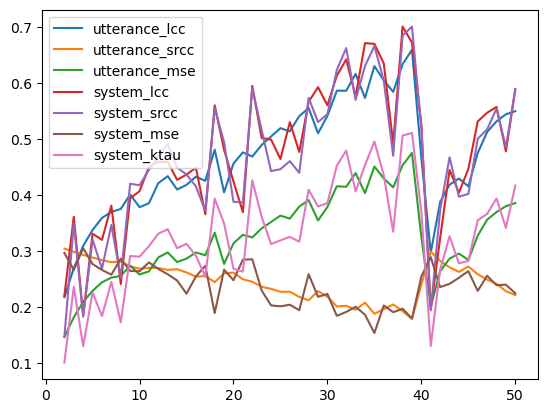

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
fig, axs = plt.subplots(len(df.columns), 1)

train_results = pd.read_csv('runs/prod/mosnet/mosnet_train_.csv')
for i, column in enumerate(train_results.columns):
    if column != 'epoch':
        train_results[column].plot(kind='line', ax=axs[i], title=column)

plt.tight_layout()
plt.show()

In [ ]:
val_results = 

In [4]:
# test baseline MOSNet model

## TODO: make sure test infers model device

test(
    model=model,
    model_name='mosnet_test',
    data_path=TEST_PATH,
    transcripts_path=TRANSCRIPTS_PATH,
    audios_path=AUDIOS_PATH,
    device=DEVICE,
    runs_dir='runs/prod/mosnet'
)

"\ntest(\n    model=model,\n    model_name='mosnet',\n    run_dir='/runs',\n    run_key='prod',\n    test_params=TEST_VAL_PARAMS\n)\n"

In [5]:
# define MOSNet model with prosody alignment

'''
model = ProsAlignMOSNet(
    stft_params=MOSNET_STFT_PARAMS,
    model_params={
        'pros_align_embedding_size': 64,
        'pros_align_ff_dim': 128,
        'pros_align_ff_dropout': 0.1,
        'pros_align_bigru_dim': 128,
        **BASELINE_MOSNET_PARAMS
    }
).to(DEVICE)
'''

"\nmodel = ProsAlignMOSNet(\n    stft_params=MOSNET_STFT_PARAMS,\n    model_params={\n        'pros_align_embedding_size': 64,\n        'pros_align_ff_dim': 128,\n        'pros_align_ff_dropout': 0.1,\n        'pros_align_bigru_dim': 128,\n        **BASELINE_MOSNET_PARAMS\n    }\n)\n"